In [1]:
!pip install catboost

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, KFold, StratifiedKFold, learning_curve
from xgboost import XGBClassifier
from sklearn import svm, linear_model
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import seaborn as sn
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from catboost import CatBoostClassifier, Pool, cv

import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [7]:
def memory_compression(df):
    original_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        
        if df[col].dtype != object:
            col_min = df[col].min()
            col_max = df[col].max()

            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            
    reduced_mem = df.memory_usage().sum()/1024**2
    
    print(f'Изначальный размер занимаемой памяти равен {round(original_mem,2)} мб.')
    print(f'Конечный размер занимаемой памяти равен {round(reduced_mem,2)} мб.')

#Постановка задачи
##Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

Метрика качества

F1-score (sklearn.metrics.f1_score)

Требования к решению

Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

##Описание датасета


*   Home Ownership - домовладение
*   Annual Income - годовой доход
*   Years in current job - количество лет на текущем месте работы
*   Tax Liens - налоговые обременения
*   Number of Open Accounts - количество открытых счетов
*   Years of Credit History - количество лет кредитной истории
*   Maximum Open Credit - наибольший открытый кредит
*   Number of Credit Problems - количество проблем с кредитом
*   Months since last delinquent - количество месяцев с последней     просрочки
*   Bankruptcies - банкротства
*   Purpose - цель кредита
*   Term - срок кредита
*   Current Loan Amount - текущая сумма кредита
*   Current Credit Balance - текущий кредитный баланс
*   Monthly Debt - ежемесячный долг
*   Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

##Загрузка данных.

In [8]:
TRAIN_DATASET_PATH = '/content/course_project_train.csv'
TEST_DATASET_PATH = '/content/course_project_test.csv'

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [10]:
train_df.shape[1] - 1 == test_df.shape[1]

True

##Оптимизация размера памяти.

#EDA

##Распределение целевой переменной.

In [11]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

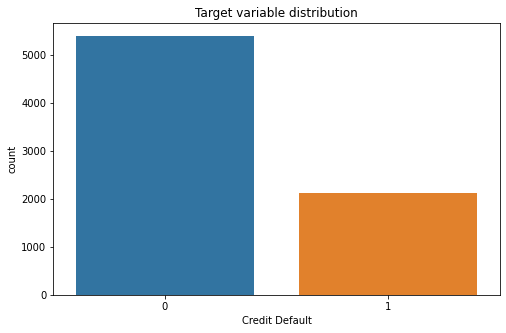

In [12]:
plt.figure(figsize=(8, 5))

sns.countplot(x='Credit Default', data=train_df)

plt.title('Target variable distribution')
plt.show()

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

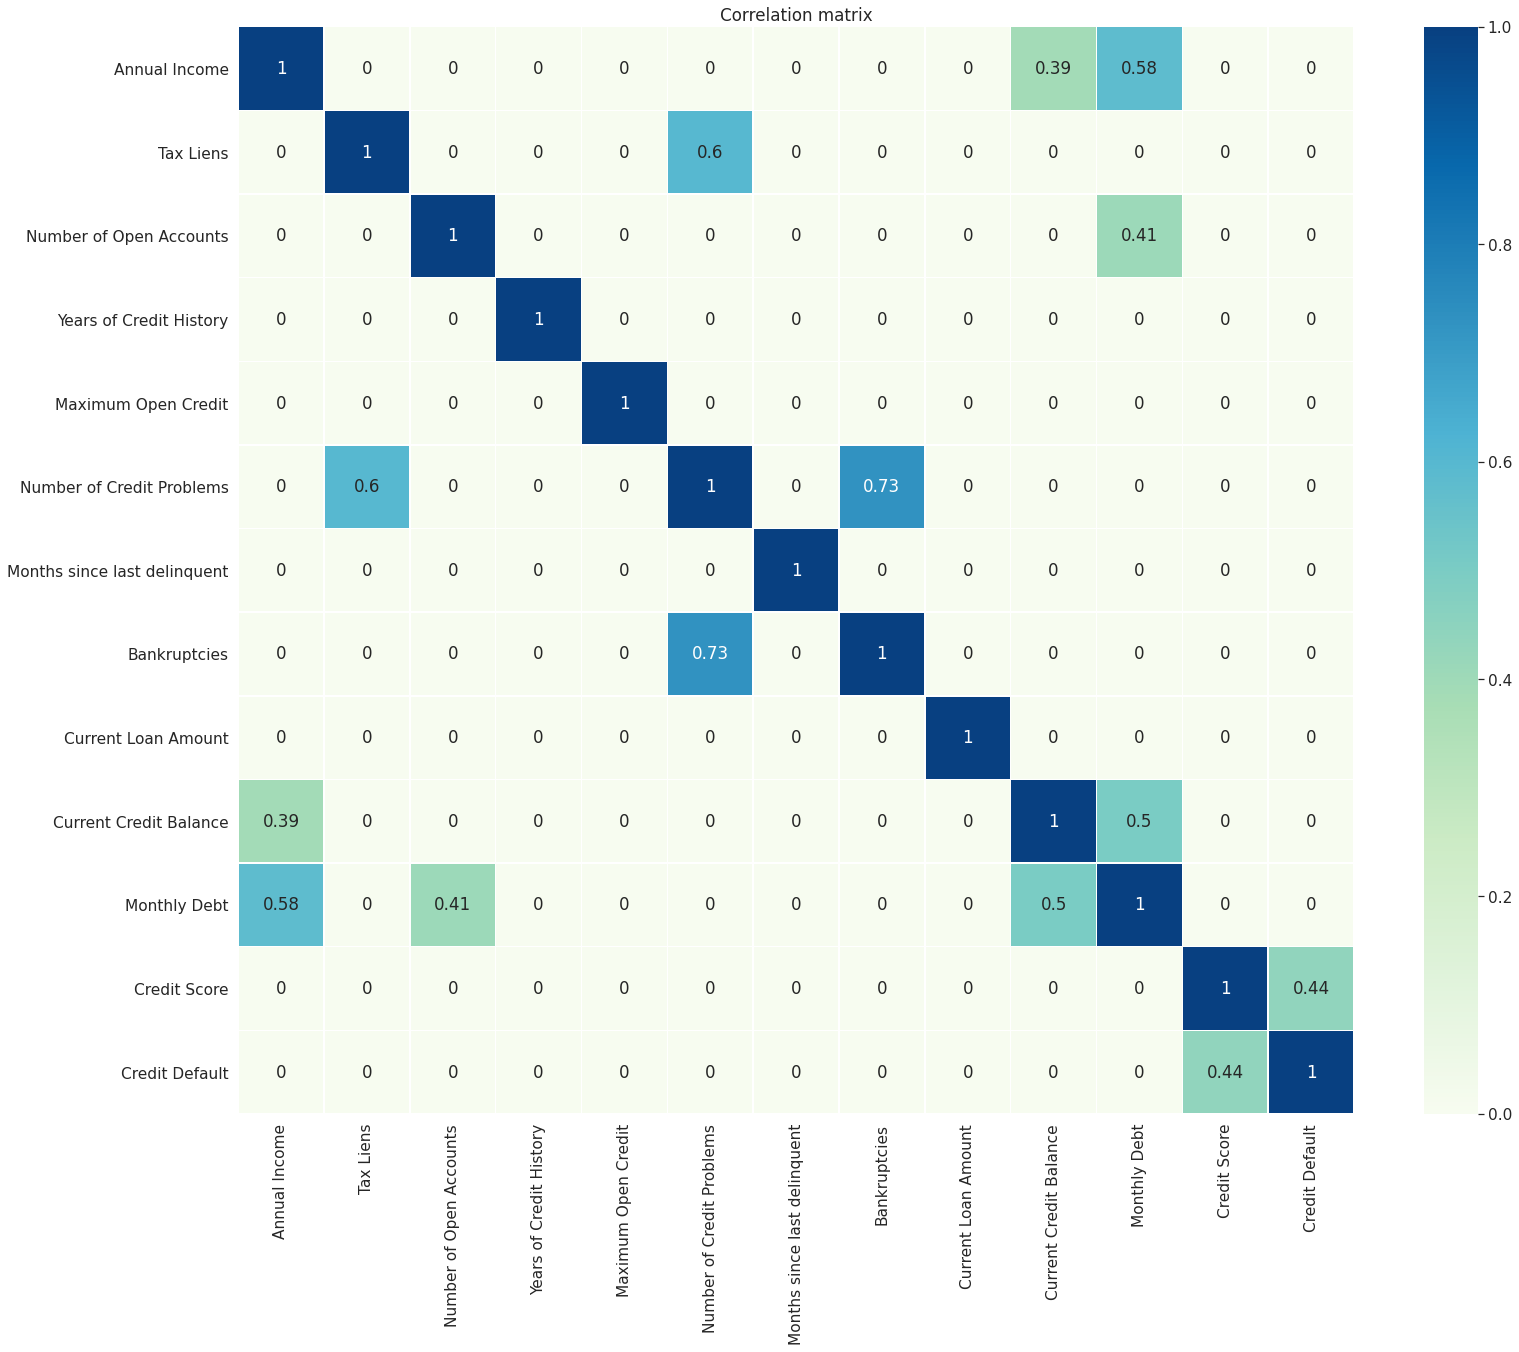

In [14]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [15]:
# Fillna and aoutliers with GBR model
def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = GradientBoostingRegressor(n_estimators=110,
                                  max_depth=8,
                                  random_state=42,
                                  loss='huber',
                                  learning_rate=0.2)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    pred = model.predict(predict_data.drop(columns=target_col))
    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [16]:
class DataPreprocessor:
    def __init__(self):
        self.medians = None
        self.years_max_quantille = None
        self.credit_max_quantille = None
        self.loan_quantille = None

    def fit(self, df):
        self.medians = df.median()
        self.years_max_quantille = np.quantile(df['Years of Credit History'], q=0.95)
        self.credit_max_quantille = np.quantile(df['Maximum Open Credit'], q=0.95)
        self.loan_quantille = np.quantile(df['Current Loan Amount'], q=0.88)

                                               
    def transform(self, df):
        # 'Home Ownership'
        # Have Mortgage = Home Mortgage
        df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'       
        # Replace obj with numeric
        df['Ownership'] = df['Home Ownership'].copy()
        df = pd.get_dummies(df, columns=['Ownership'])
        df.replace({'Home Ownership': {'Own Home': 2, 
                                       'Home Mortgage': 1, 
                                       'Rent': 0}
                    }, inplace=True)


        # 'Years in current job' 
        # Replace obj with numeric
        df.replace({'Years in current job': 
                                            {'10+ years': 10,
                                             '9 years': 9, 
                                             '8 years': 8,
                                             '7 years': 7, 
                                             '6 years': 6,
                                             '5 years': 5,
                                             '4 years': 4,
                                             '3 years': 3,
                                             '2 years': 2,
                                             '1 year': 1,
                                             '< 1 year': 0,}}, inplace=True)
        # Fillna
        self.years_in_cur_job_median = df['Years in current job'].median()
        df['Years in current job'].fillna(self.years_in_cur_job_median, inplace=True)


        # 'Purpose'
        df.replace({'Purpose': 
                                            {'debt consolidation': 0,
                                             'other': 1, 
                                             'home improvements': 1,
                                             'take a trip': 1, 
                                             'buy a car': 1,
                                             'small business': 2,
                                             'business loan': 2,
                                             'wedding': 1,
                                             'educational expenses': 1,
                                             'buy house': 1,
                                             'medical bills': 1,
                                             'moving': 1,
                                             'major purchase': 1,
                                             'vacation':1,
                                             'renewable energy':1, }}, 
                   inplace=True)
        # Fillna
        df['Purpose'].fillna(1, inplace=True)


        # 'Term'
        df.replace({'Term': {'Short Term': 0, 
                             'Long Term': 1}}, inplace=True)
        

        # 'Months since last delinquent'
        # Fillna with number of credit history months
        df['Months since last delinquent'].fillna((df['Years of Credit History'] * 12), inplace=True)


        # 'Annual Income'
        df['Annual Income'].fillna(1, inplace=True)


        # 'Credit Score'
        df['Credit Score'].fillna(1, inplace=True)
        df.loc[df['Credit Score'] > 850, ['Credit Score']] = df['Credit Score'] / 10


        # 'Bankruptcies'
        df['Bankruptcies'].fillna(0, inplace=True)
        
        
        # 'Years of Credit History'
        df['Years of Credit History'].clip(lower=None, upper=self.years_max_quantille, inplace=True)

        
        # Fillna with GBR model
        df.loc[df['Annual Income'] == 1, ['Annual Income']] = np.nan
        model, df = imputer_rfr(df, 'Annual Income')

        df.loc[df['Credit Score'] == 1, ['Credit Score']] = np.nan
        model, df = imputer_rfr(df, 'Credit Score')


        df.loc[df['Current Loan Amount'] >= self.loan_quantille, ['Current Loan Amount']] = np.nan
        model, df = imputer_rfr(df, 'Current Loan Amount')


        df.loc[df['Maximum Open Credit'] > self.credit_max_quantille, ['Maximum Open Credit']] = np.nan
        model, df = imputer_rfr(df, 'Maximum Open Credit')

        self.months_since_deliq_quantille = np.quantile(df['Months since last delinquent'], q=0.92)
        df.loc[df['Months since last delinquent'] > self.months_since_deliq_quantille, ['Months since last delinquent']] = np.nan
        model, df = imputer_rfr(df, 'Months since last delinquent')
        
        
        # Fillna just in case
        df.fillna(self.medians, inplace=True)

        return df

In [17]:
class FeatureGenerator:
    def __init__(self):
        self.median = None
        self.ownership_rating = None
        self.job_years_rating = None
        self.credit_default_score_mode = None
        self.median_loan_by_purpose = None

    def fit(self, df):
        self.medians = df.median()
        self.ownership_rating = df.groupby(['Home Ownership'])['Credit Score'].agg('median').to_dict()
        self.job_years_rating = df.groupby(['Years in current job'])['Credit Score'].agg('median').to_dict()
        self.credit_default_score_mode = df.groupby(['Credit Default'])['Credit Score'].agg(pd.Series.mode)[1]
        self.median_loan_by_purpose = df.groupby(['Purpose'])['Current Loan Amount'].agg('median').to_dict()

    def transform(self, df):
        # 'Credit to income ratio'
        df['Credit to income ratio'] = np.round((df['Annual Income']/12) / df['Monthly Debt'], 3)
        df.loc[df['Credit to income ratio'] == np.inf, ['Credit to income ratio']] = df['Credit to income ratio'].median()
        
        # 'Loan to income ratio'
        df['Loan to income ratio'] = np.round((df['Annual Income']/12) / df['Current Loan Amount'], 3)
        df.loc[df['Loan to income ratio'] == np.inf, ['Loan to income ratio']] = df['Loan to income ratio'].median()
        
        # 'Ownership_credit_rating'
        df['Ownership_credit_rating'] = df['Home Ownership'].map(self.ownership_rating)

        # 'Years in job rating'
        df['Years in job rating'] = df['Years in current job'].map(self.job_years_rating)
        
        # 'Credit Default Score Delta'
        df['Credit Default Score Delta'] = abs(df['Credit Score'] - self.credit_default_score_mode)

        # 'Loan_by_term'
        df['Loan_by_term'] = df['Purpose'].map(self.median_loan_by_purpose)

        df['Id'] = df.index.to_list()

        
        return df

##Обработка данных.

In [18]:
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)


feature_gen = FeatureGenerator()
feature_gen.fit(train_df)
train_df = feature_gen.transform(train_df)
test_df = feature_gen.transform(test_df)

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   int64  
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   int64  
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

##Разбиение на train и test

In [20]:
TARGET = 'Credit Default'
X = train_df.drop(TARGET, axis=1)
y = train_df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=100)

In [21]:
X_train.isna().sum().sum(), X_test.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [22]:
disbalance = int(y_train.value_counts()[0]) / int(y_train.value_counts()[1])
disbalance

2.605769230769231

##Построение модели.

In [23]:
final_model = CatBoostClassifier(silent=True, random_state=100,
                                    #  cat_features=CAT_FEATURE_NAMES,
                                    class_weights=[1, disbalance],
                                    allow_writing_files=False,
                                    learning_rate=0.2,
                                    max_depth=3,
                                    n_estimators=150,
                                    eval_metric='F1',
                                    reg_lambda=2.617721518987342,
                                    early_stopping_rounds=30,
                                    use_best_model=True,
                                    custom_metric=['Precision', 'Recall'],
                                    subsample=0.8,)
                                     
final_model.fit(X_train, y_train, eval_set=(X_test, y_test))
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)



TRAIN

              precision    recall  f1-score   support

           0       0.87      0.64      0.74      3794
           1       0.45      0.76      0.56      1456

    accuracy                           0.67      5250
   macro avg       0.66      0.70      0.65      5250
weighted avg       0.76      0.67      0.69      5250

TEST

              precision    recall  f1-score   support

           0       0.85      0.62      0.71      1593
           1       0.44      0.74      0.55       657

    accuracy                           0.65      2250
   macro avg       0.65      0.68      0.63      2250
weighted avg       0.73      0.65      0.67      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               980  613
1               173  484


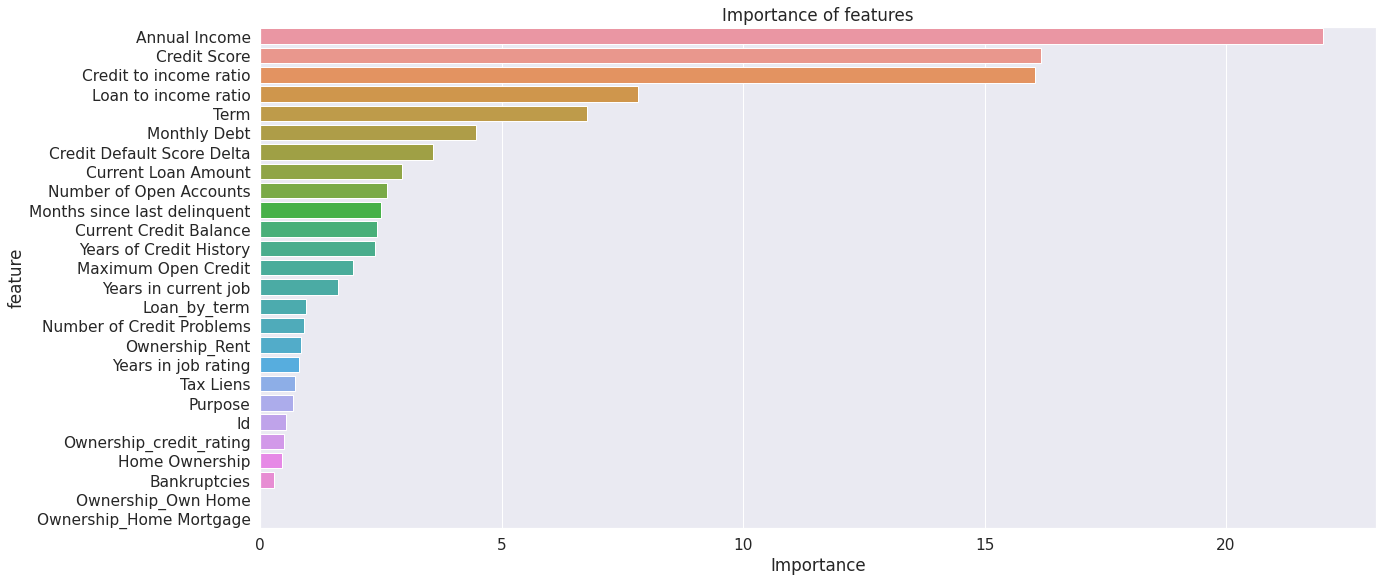

In [24]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [25]:
test_df['Credit Default'] = final_model.predict(test_df)

In [27]:
test_df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Ownership_Home Mortgage,Ownership_Own Home,Ownership_Rent,Credit to income ratio,Loan to income ratio,Ownership_credit_rating,Years in job rating,Credit Default Score Delta,Loan_by_term,Id,Credit Default
0,0,8.015743e+05,4.0,0.0,9.0,12.5,2.209680e+05,0.0,70.000000,0.0,0,0,162470.000000,105906.0,6813.0,729.403593,0,0,1,9.804,0.411,727.033362,728.000000,7.596407,282613.919588,0,1
1,0,2.318380e+05,1.0,0.0,6.0,31.9,5.594600e+04,0.0,8.000000,0.0,1,0,78298.000000,46037.0,2318.0,699.000000,0,0,1,8.335,0.247,727.033362,729.689134,38.000000,196020.000000,1,1
2,1,1.152540e+06,3.0,0.0,10.0,13.7,2.046000e+05,0.0,164.400000,0.0,0,0,200178.000000,146490.0,18729.0,726.000000,1,0,0,5.128,0.480,730.000000,729.000000,11.000000,282613.919588,2,1
3,1,1.220313e+06,10.0,0.0,16.0,17.0,4.563020e+05,0.0,70.000000,0.0,0,0,217382.000000,213199.0,27559.0,739.000000,1,0,0,3.690,0.468,730.000000,728.058501,2.000000,282613.919588,3,0
4,1,2.340952e+06,6.0,0.0,11.0,23.6,1.207272e+06,0.0,283.200000,0.0,0,1,777634.000000,425391.0,42605.0,706.000000,1,0,0,4.579,0.251,730.000000,728.811667,31.000000,282613.919588,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1,1.020053e+06,10.0,0.0,14.0,29.1,5.591520e+05,1.0,68.000000,1.0,0,0,248968.963588,162735.0,15046.0,745.000000,1,0,0,5.650,0.341,730.000000,728.058501,8.000000,282613.919588,2495,0
2496,1,2.388012e+06,2.0,0.0,15.0,17.0,1.598840e+06,0.0,77.000000,0.0,0,0,468512.000000,1439269.0,32996.0,733.365737,1,0,0,6.031,0.425,730.000000,730.000000,3.634263,282613.919588,2496,0
2497,1,1.171806e+06,2.0,0.0,48.0,12.8,1.216284e+06,0.0,153.600000,0.0,0,0,430496.000000,676438.0,36912.0,695.000000,1,0,0,2.645,0.227,730.000000,730.000000,42.000000,282613.919588,2497,1
2498,0,7.235200e+05,10.0,0.0,14.0,28.8,9.457800e+05,0.0,66.573433,0.0,0,0,257774.000000,391248.0,13506.0,744.000000,0,0,1,4.464,0.234,727.033362,728.058501,7.000000,282613.919588,2498,1


In [28]:
predictions = test_df['Credit Default']

In [29]:
predictions['Id'] = predictions.index.to_list()

In [30]:
predictions

0                                                       1
1                                                       1
2                                                       1
3                                                       0
4                                                       1
                              ...                        
2496                                                    0
2497                                                    1
2498                                                    1
2499                                                    1
Id      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
Name: Credit Default, Length: 2501, dtype: object

In [31]:
predictions.to_csv("VVdovichev_predictions.csv", index=False)